In [2]:
import pandas as pd

df = pd.read_csv('output.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

df.head()

,cycle,time_charge,time_discharge,Discharge voltage_measured,Discharge current_measured,Charging Voltage,Charging Current,Power Out,Power In,Temp Discharge,Temp Charge,Output Energy,Input Energy,cap_ratio,imp_ratio
0,1,10289.312,3591.734,3.552038,-1.855346,4.079851,0.941164,6.629801,3.800934,35.208398,24.959154,23797.592119,26642.736309,[1.],[1.]
1,2,10283.078,3552.297,3.552567,-1.874700,4.057904,0.961287,6.697785,3.850354,36.348993,25.413968,23797.696584,27359.989409,[1.00021186],[0.98695233]
2,3,10281.390,3531.578,3.556794,-1.873827,4.056384,0.963212,6.697810,3.856286,35.857118,25.126172,23666.577683,27345.396909,[0.99412646],[0.97671868]
3,4,10081.797,3492.907,3.561410,-1.883194,4.058279,0.969751,6.733348,3.887255,35.775393,24.757206,23539.487839,27153.281627,[0.98849759],[0.98587557]
4,5,10797.328,3511.594,3.556611,-1.873239,4.065739,0.931057,6.693233,3.736190,35.492816,24.374805,23514.714733,26913.835643,[0.98813641],[0.97652689]


In [3]:
# converting cap_ratio and imp_ratio from string to float

df['cap_ratio'] = df['cap_ratio'].apply(lambda x: float(x.strip('[]')) if isinstance(x, str) else x)
df['imp_ratio'] = df['imp_ratio'].apply(lambda x: float(x.strip('[]')) if isinstance(x, str) else x)

# Display the updated DataFrame
df.head()

,cycle,time_charge,time_discharge,Discharge voltage_measured,Discharge current_measured,Charging Voltage,Charging Current,Power Out,Power In,Temp Discharge,Temp Charge,Output Energy,Input Energy,cap_ratio,imp_ratio
0,1,10289.312,3591.734,3.552038,-1.855346,4.079851,0.941164,6.629801,3.800934,35.208398,24.959154,23797.592119,26642.736309,1.000000,1.000000
1,2,10283.078,3552.297,3.552567,-1.874700,4.057904,0.961287,6.697785,3.850354,36.348993,25.413968,23797.696584,27359.989409,1.000212,0.986952
2,3,10281.390,3531.578,3.556794,-1.873827,4.056384,0.963212,6.697810,3.856286,35.857118,25.126172,23666.577683,27345.396909,0.994126,0.976719
3,4,10081.797,3492.907,3.561410,-1.883194,4.058279,0.969751,6.733348,3.887255,35.775393,24.757206,23539.487839,27153.281627,0.988498,0.985876
4,5,10797.328,3511.594,3.556611,-1.873239,4.065739,0.931057,6.693233,3.736190,35.492816,24.374805,23514.714733,26913.835643,0.988136,0.976527


In [4]:
# creating the target column using linear combination of cap_ratio and imp_ratio
df['soh'] = (0.5)*df['cap_ratio'] + (0.5)*df['imp_ratio']
df.drop(columns=['cap_ratio', 'imp_ratio'], inplace=True)

In [5]:
# creating a feature called "efficiency" measuring the conversion efficiency of total stored energy to useful work
df['Efficiency']=df['Output Energy']/df['Input Energy']
# dropping the above two column as we have used them to create a new feature
df.drop(columns=['Output Energy', 'Input Energy'], inplace=True)

# creating a feature
df['time_ratio']=df['time_charge']/df['time_discharge']
df.drop(columns=['time_charge', 'time_discharge'], inplace=True)

# creating a feature called "power_efficiency" measuring the efficiency of average 
# looking very similar to "efficiency"
df['power_efficiency'] = df['Power Out']/df['Power In']
df.drop(columns=['Power Out', 'Power In'], inplace=True)

# creating feature res_ch and res_dc
df['res_ch'] = df['Charging Voltage'] / df['Charging Current']
df['res_dc'] = df['Discharge voltage_measured'] / df['Discharge current_measured']
# dropping the above two features
df.drop(columns=['Charging Voltage', 'Charging Current', 'Discharge voltage_measured', 'Discharge current_measured'], inplace=True)

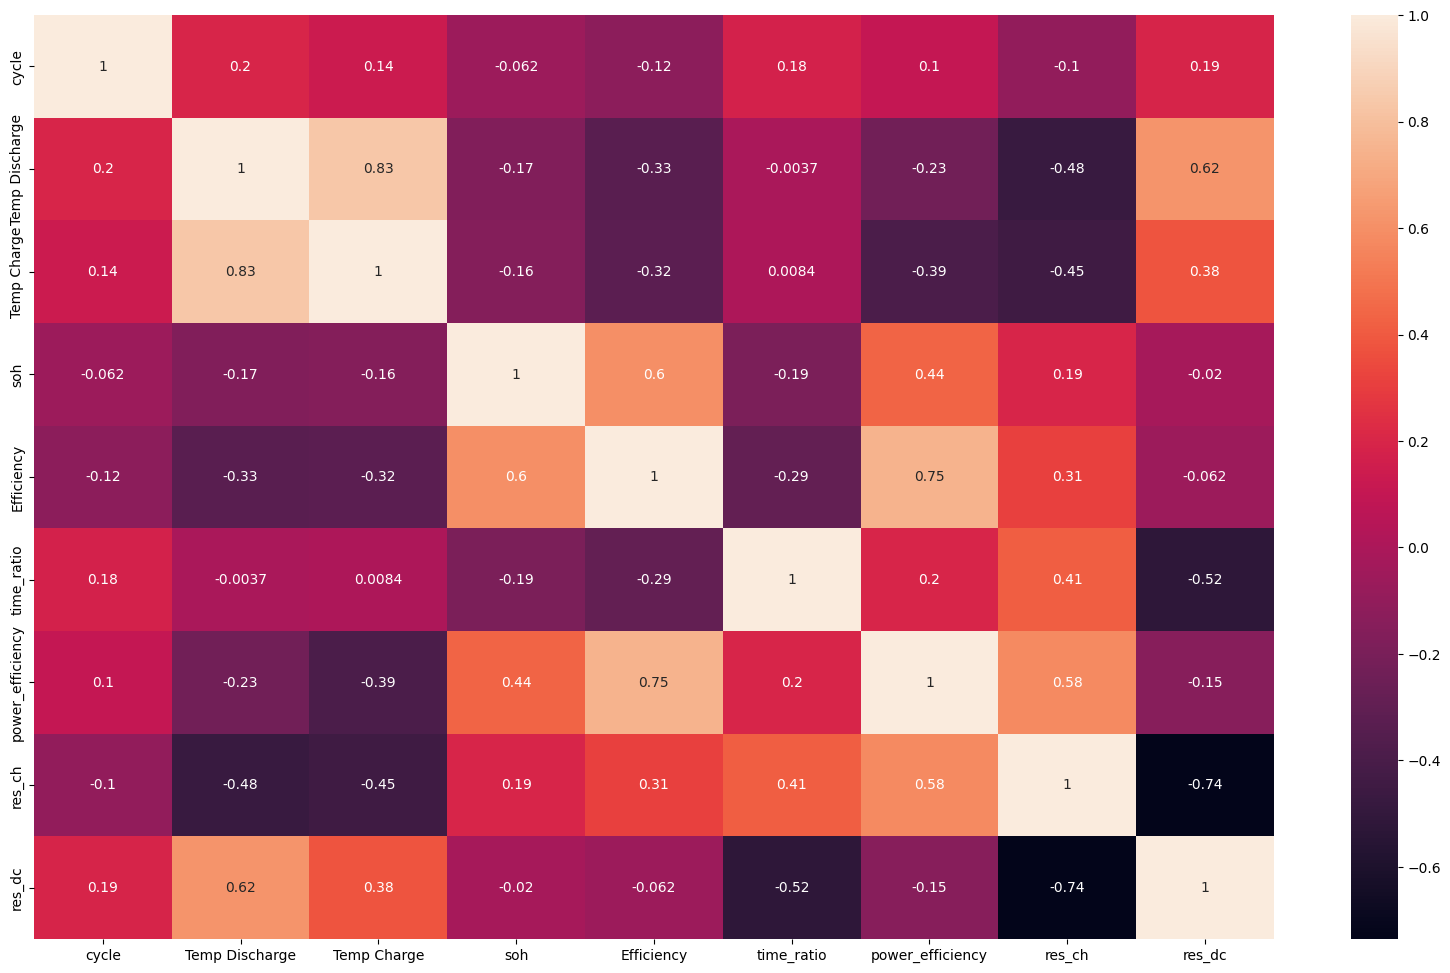

In [6]:
# plotting a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [8]:
# choosing input and output column
X = df.drop(columns=['soh'])
y= df['soh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
print(X.columns)

Index(['cycle', 'Temp Discharge', 'Temp Charge', 'Efficiency', 'time_ratio',
       'power_efficiency', 'res_ch', 'res_dc'],
      dtype='object')


In [10]:
# scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Random Forest

In [11]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(mean_squared_error(y_pred_rf, y_test))

0.001050826764316421


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor()

# Define the expanded parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for RandomForest:", grid_search_rf.best_params_)
print("Best score for RandomForest:", grid_search_rf.best_score_)

# Predict on test set
y_pred_rf = grid_search_rf.predict(X_test)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best parameters for RandomForest: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best score for RandomForest: 0.5397482340593411


# XG Boost

In [13]:
xg = XGBRegressor()

xg.fit(X_train, y_train)

y_pred_xg = xg.predict(X_test)
print(mean_squared_error(y_pred_xg, y_test))

0.0008478265764556829


In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
xgb = XGBRegressor()

# Define the expanded parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best score for XGBoost:", grid_search_xgb.best_score_)

# Predict on test set
y_pred_xgb = grid_search_xgb.predict(X_test)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.9}
Best score for XGBoost: 0.6169926288342777


In [15]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_pred_xgb, y_test), mean_squared_error(y_pred_rf, y_test))

0.0009936085946614136 0.001000393192932701


#### ANN

In [16]:
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(restore_best_weights=True, monitor='loss', patience=10)

In [17]:
X_test.shape

(46, 8)

In [18]:
model=Sequential()
model.add(Dense(units=16, activation='relu', input_dim=8))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

c:\Users\anasm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.fit(X_train, y_train, epochs=500, callbacks=early_stopping)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1385   
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 2.1219
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.9079
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.8646
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.7047
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.5720
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5314 
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.5301
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.3120
Epoch 10/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.2746
Epoch 11/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.9268
Epoch 12/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.4296
Epoch 13/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.2654
Epoch 14/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.1441
Epoch 15/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [20]:
y_pred_ann=model.predict(X_test)
print(mean_squared_error(y_pred_ann, y_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0.008777761995587528


In [21]:
X.columns

Index(['cycle', 'Temp Discharge', 'Temp Charge', 'Efficiency', 'time_ratio',
       'power_efficiency', 'res_ch', 'res_dc'],
      dtype='object')

In [22]:
mean_absolute_error(y_test, y_pred_ann)

0.03571529996538245